# SimpleRNN for Google Stock Prediction

## Data Pre-processing

In [56]:
# %pip install tensorflow

In [103]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [104]:
# Load data from csv
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.head())
# Only interested in opening price data
GoogOpen = data[['Date', 'Open']]
GoogOpen.set_index('Date', inplace=True)
print(GoogOpen.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
                Open
Date                
2004-08-19  2.490664
2004-08-20  2.515820
2004-08-23  2.758411
2004-08-24  2.770615
2004-08-25  2.614201


### Training/Testing Split

We will first split the data as 90/10 

In [105]:
# Perform 90/10 split
split_index = int(len(GoogOpen) * 0.9) - 50  # Go back 50 days so prediction starts on 12/30/2021
train_open = GoogOpen[:split_index]
test_open = GoogOpen[split_index:]

print(train_open.shape, test_open.shape)
train_open.head()

(4322, 1) (536, 1)


,Open
Date,
2004-08-19,2.490664
2004-08-20,2.515820
2004-08-23,2.758411
2004-08-24,2.770615
2004-08-25,2.614201


In [106]:
# Reshape data into 2-D array
train_dataset = np.reshape(train_open, (-1,1))
print(train_dataset.shape)

test_dataset = np.reshape(test_open, (-1,1))
print(test_dataset.shape)

(4322, 1)
(536, 1)


### Data Normalization

Transforming data values to a (0,1) scale 

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

train_dataset_scaled = scaler.fit_transform(train_dataset)
test_dataset_scaled = scaler.fit_transform(test_dataset)

### Divide into X and y Datasets

We will create X_train, y_train, X_test, and y_test datasets to form this into a supervised learning problem. We will use a time step of 50 days for training.

In [108]:
# creating X and y for training data

time_step = 50
train_length = len(train_open)

X_train = []
y_train = []

for i in range(time_step, train_length):
    X_train.append(train_dataset_scaled[i - time_step:i,0])
    y_train.append(train_dataset_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4272, 50)
(4272,)


In [109]:
# creating X and y for testing data
test_length = len(test_open)
X_test = []
y_test = []

for i in range(time_step, test_length):
    X_test.append(test_dataset_scaled[i - time_step:i,0])
    y_test.append(test_dataset_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(486, 50)
(486,)


In [110]:
# Reshape train data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

print(X_train.shape)
print(y_train.shape)

(4272, 50, 1)
(4272, 1)


In [111]:
# Reshape test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(X_test.shape)
print(y_test.shape)

(486, 50, 1)
(486, 1)


## Building a Simple RNN Model
### Specifying and Fitting Model
We will build a SimpleRNN model with 2 SimpleRNN layers, each with a Dropout layer, and a Dense output. The SimpleRNN will use the tanh activation function, which is common for modeling time series. Additionally we will use the Adam optimizer and an mse loss function. We will use 60 epochs and a batch size of 32.

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define the model
model = Sequential()

model.add(SimpleRNN(units=50, 
                    activation="tanh",
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))

# Dropout layer to reduce overfitting
model.add(Dropout(0.3))

model.add(SimpleRNN(units=50,
                    activation="tanh",
                    return_sequences=False))

model.add(Dropout(0.3))

# Output Dense layer
model.add(Dense(1))  # For time series regression, use 1 output neuron

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

# Fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 60, batch_size = 32)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_20 (SimpleRNN)       │ (None, 50, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1104 - val_loss: 0.0076
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - val_loss: 0.0044
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 9/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 10/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 11/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 12/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

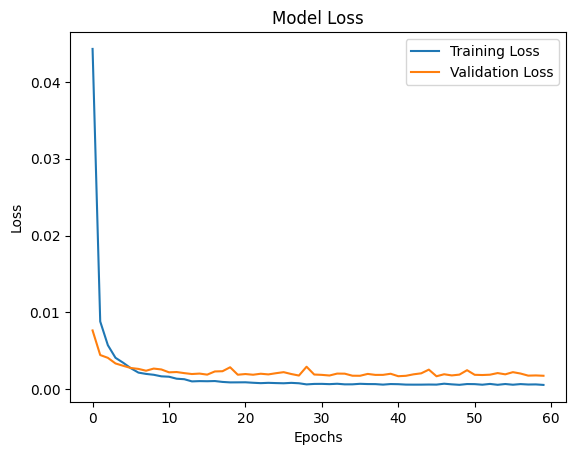

In [116]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Taking a look at the new Epoch vs Loss graph for the training and validation data, we see that the loss for both data sets seems to be decreasing and converging, so our model appears to be a good fit and we do not have many indications of overfitting.

### Making Predictions

Here we are predicting values and then undoing the normalization/scaling to get the predictions back in the original price scale.

In [117]:
# Make predictions on the training and test set
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and true values to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train)

test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Visualizing Model

In [118]:
# Extract the corresponding dates for training and test data
train_dates = GoogOpen.index[:len(train_predictions)]
test_dates = GoogOpen.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

### Plot Training Data with Predition

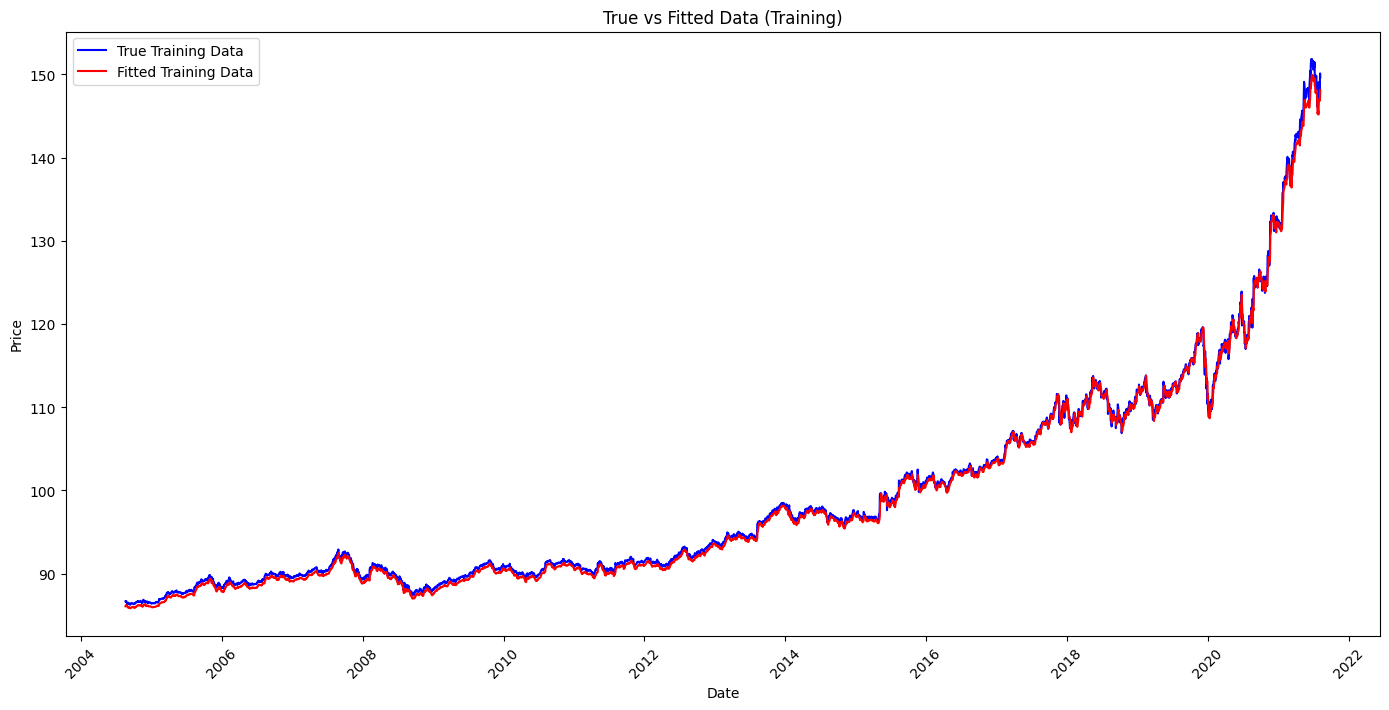

In [119]:
plt.figure(figsize=(14, 7))

# Plot training data with dates on the x-axis
plt.plot(train_dates, y_train_actual, color='blue', label='True Training Data')
plt.plot(train_dates, train_predictions, color='red', label='Fitted Training Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Training)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()

### Plot Testing Data with Prediction

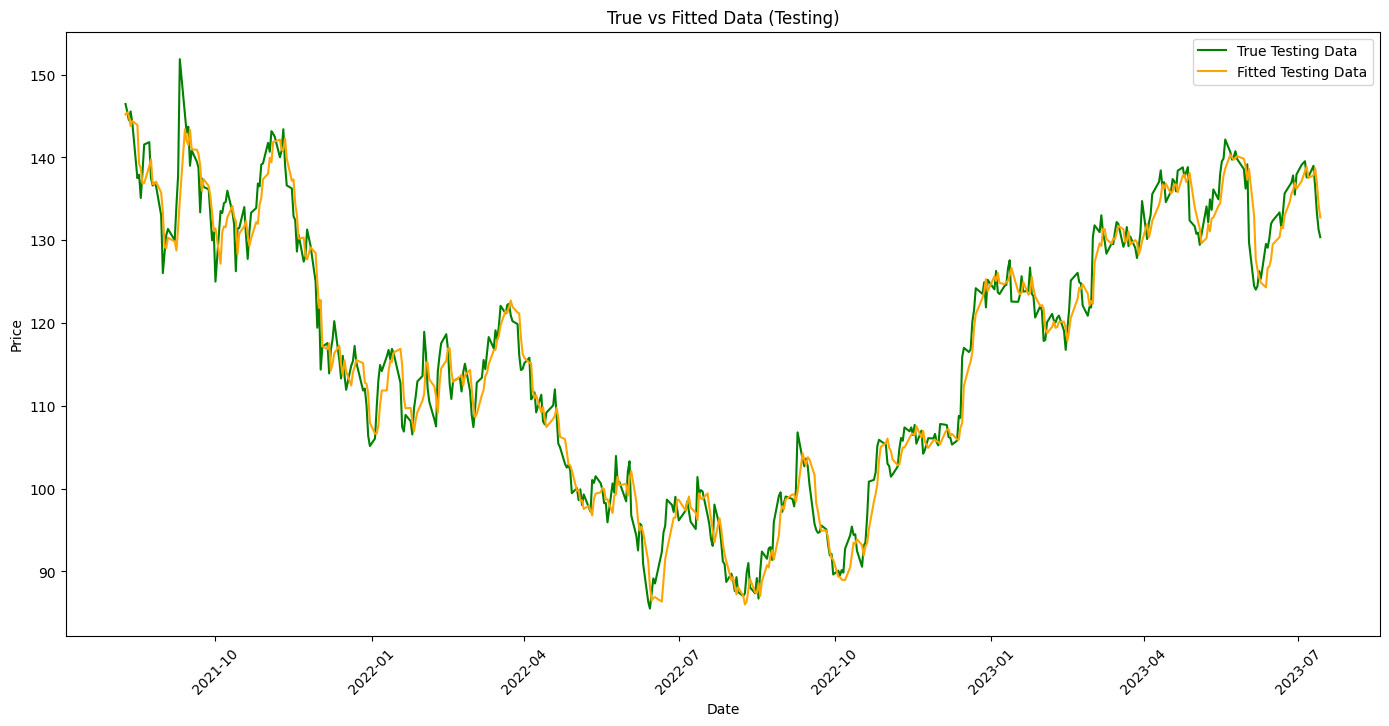

In [120]:
plt.figure(figsize=(14, 7))

# Plot testing data with dates on the x-axis
plt.plot(test_dates, y_test_actual, color='green', label='True Testing Data')
plt.plot(test_dates, test_predictions, color='orange', label='Fitted Testing Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Testing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()

### Plot Training and Testing Data with Prediction

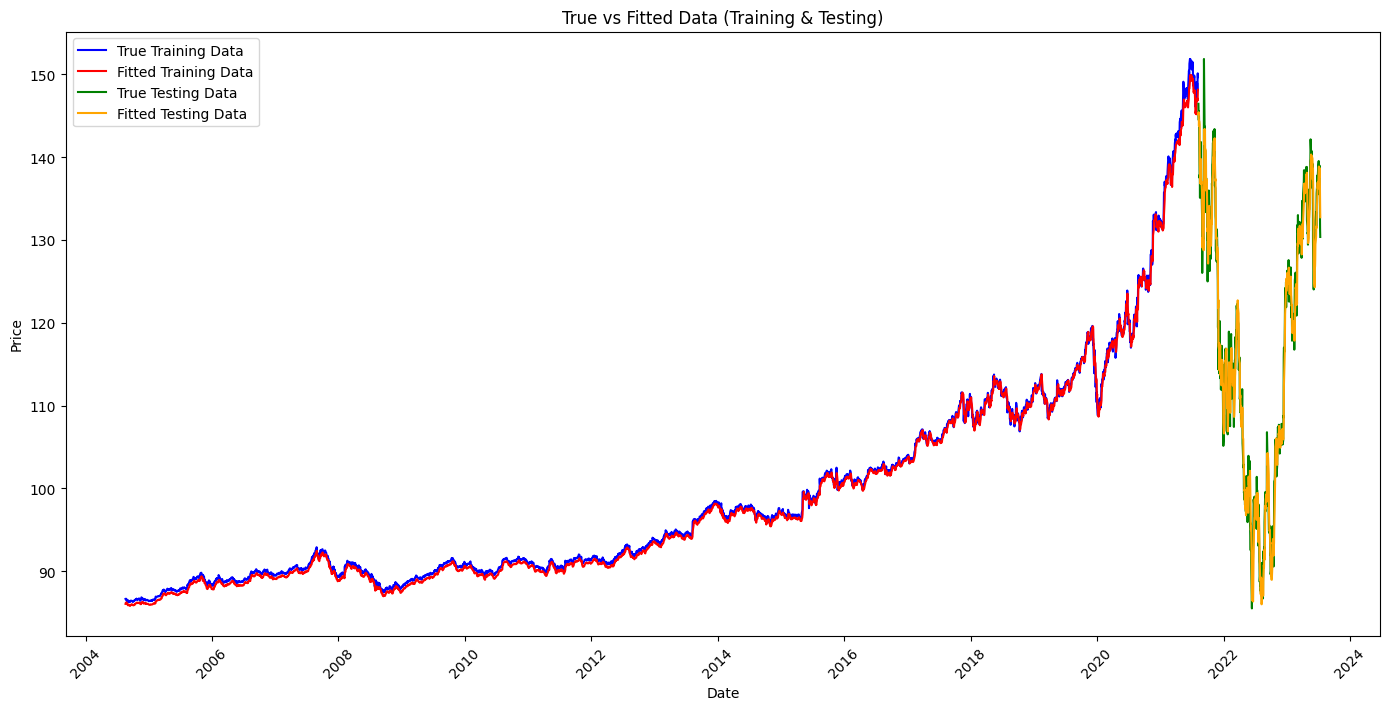

In [121]:
plt.figure(figsize=(14, 7))

# Plot training and testing data with dates on the x-axis
plt.plot(train_dates, y_train_actual, color='blue', label='True Training Data')
plt.plot(train_dates, train_predictions, color='red', label='Fitted Training Data')
plt.plot(test_dates, y_test_actual, color='green', label='True Testing Data')
plt.plot(test_dates, test_predictions, color='orange', label='Fitted Testing Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Training & Testing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()


## Evaluating Model

We will again take a look at the MSE, MAE, RMSE, MAPE to evaluate the fit of the model for both the training and testing predictions.

### Training Prediction Metrics

In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE, MAE, RMSE, and MAPE for training data
train_mse = mean_squared_error(y_train_actual, train_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train_actual - train_predictions) / y_train_actual))

# Print the results
print(f'Train MSE: {train_mse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train MAPE: {train_mape:.4f}')

Train MSE: 0.2981
Train MAE: 0.4403
Train RMSE: 0.5460
Train MAPE: 0.0044


### Testing Prediction Metrics

In [123]:
test_mse = mean_squared_error(y_test_actual, test_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual))

# Print the results
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAPE: {test_mape:.4f}')

Test MSE: 7.7064
Test MAE: 2.1237
Test RMSE: 2.7760
Test MAPE: 0.0184


### Single Day (Next-Day) Prediction
Take a look at the next prediction 

In [124]:
# Predicted next day's value
rnn_next_day_pred = test_predictions[0][0]

# Extract the true value for comparison
rnn_next_day_true = GoogOpen.iloc[split_index + 50]['Open']

# Calculate prediction error
rnn_pred_error = abs(rnn_next_day_true - rnn_next_day_pred)

# Print results
print("True value for the next day:", rnn_next_day_true)
print("Predicted value for the next day:", rnn_next_day_pred)
print("Prediction error (absolute):", rnn_pred_error)

True value for the next day: 146.449997
Predicted value for the next day: 145.19081
Prediction error (absolute): 1.2591858427734337
